## Hand-written digit classification
2018-10-23 Jeff Fessler, University of Michigan  

In [1]:
# packages needed
using Plots
using LinearAlgebra # svd, norm, etc.
using Statistics: mean
using Random

### Load the data and look at it  

In [2]:
# read the MNIST data file for 0 and 1 digits
# download from web if needed
file0 = "data4"
file1 = "data9"
if !isfile(file0)
    download("http://cis.jhu.edu/~sachin/digit/" * file0, file0)
end
if !isfile(file1)
    download("http://cis.jhu.edu/~sachin/digit/" * file1, file1)
end

nx = 28 # original image size
ny = 28
nrep = 1000

d0 = Array{UInt8}(undef, (nx,ny,nrep))
read!(file0, d0) # load images

d1 = Array{UInt8}(undef, (nx,ny,nrep))
read!(file1, d1) # load images

iy = 2:ny
d0 = d0[:,iy,:] # Make images non-square to help debug
d1 = d1[:,iy,:]
ny = length(iy)

# Convert images to Float32 to avoid overflow errors
d0 = Array{Float32}(d0)
d1 = Array{Float32}(d1)

@show size(d0);

size(d0) = (28, 27, 1000)


In [3]:
# function to display mosaic of multiple images
function imshow3(x)
    tmp = permutedims(x, [1, 3, 2])
    tmp = reshape(tmp, :, ny)
    return heatmap(1:size(tmp,1), 1:ny, tmp,
        xtick=[1,nx], ytick=[1,ny], yflip=true,
        color=:grays, transpose=true, aspect_ratio=1)
end

imshow3 (generic function with 1 method)

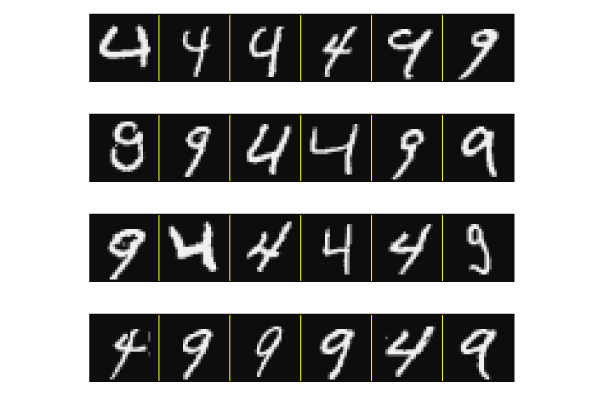

In [4]:
# look at sorted and unsorted images to show (un)supervised
Random.seed!(0)
nrow = 4
ncol = 6
t0 = d0[:,:,1:Int(nrow*ncol/2)]
t0[:,:,6] = d0[:,:,222] # include one ambiguous case
t1 = d1[:,:,1:Int(nrow*ncol/2)]
tmp = cat(t0, t1, dims=3)

tmp = tmp[:,:,randperm(size(tmp,3))] # for unsupervised

pl = []
for ii=1:nrow
    p = imshow3(tmp[:,:,(1:ncol) .+ (ii-1)*ncol])
    plot!(p, colorbar=:none)
    for jj=1:(ncol-1)
        c = :yellow # unsup
#       c = ii <= nrow/2 ? :blue : :red
        plot!([1; 1]*jj*nx, [1; ny], label="", color=c, xtick=[], ytick=[], axis=:off)
    end
    push!(pl, p)
end
plot(pl..., layout=(nrow,1))
#savefig("02-digit-rand.pdf")
#savefig("02-digit-sort.pdf")

In [5]:
# use some data for training, and some for test
ntrain = 100
ntest = nrep - ntrain
train0 = d0[:,:,1:ntrain] # training data
train1 = d1[:,:,1:ntrain]
test0 = d0[:,:,(ntrain+1):end] # testing data
test1 = d1[:,:,(ntrain+1):end];

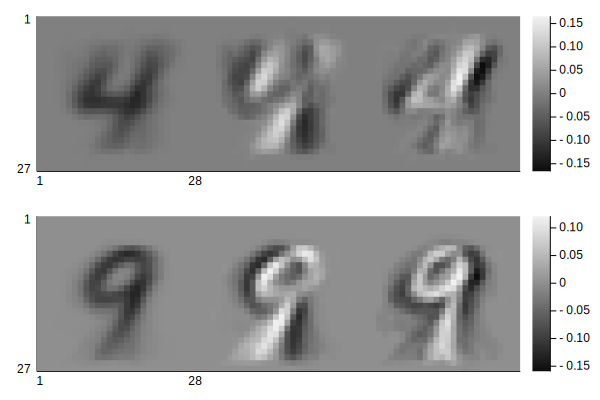

In [6]:
# svd for singular vectors and low-rank subspace approximation
u0, _, _ = svd(reshape(train0, nx*ny, :))
u1, _, _ = svd(reshape(train1, nx*ny, :))
r0 = 3 # selected ranks
r1 = 3
q0 = reshape(u0[:,1:r0], nx, ny, :)
q1 = reshape(u1[:,1:r1], nx, ny, :)
p0 = imshow3(q0)
p1 = imshow3(q1)
plot(p0, p1, layout=(2,1))

### Examine how well the first left singular vectors separate the two classes  

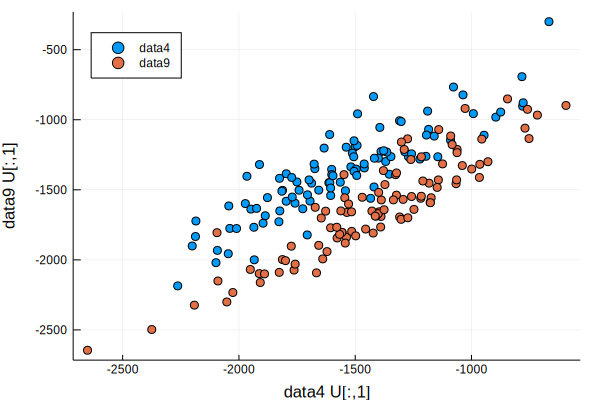

In [7]:
regress = (data, u) -> mapslices(slice -> u'*slice[:], data, dims=(1,2))[:]
 scatter(regress(train0, u0[:,1]), regress(train0, u1[:,1]), label=file0)
scatter!(regress(train1, u0[:,1]), regress(train1, u1[:,1]), label=file1)
plot!(xlabel = file0 * " U[:,1]", ylabel = file1 * " U[:,1]", legend=:topleft)

### Classify test digits based on nearest subspace  

In [8]:
Q0 = reshape(q0, nx*ny, r0)
Q1 = reshape(q1, nx*ny, r1)

y0 = reshape(test0, nx*ny, :)
y00 = y0 - Q0 * (Q0' * y0)
y01 = y0 - Q1 * (Q1' * y0)
correct0 = (mapslices(norm, y00, dims=1) .< mapslices(norm, y01, dims=1))[:]
@show sum(correct0) / ntest

y1 = reshape(test1, nx*ny, :)
y10 = y1 - Q0 * (Q0' * y1)
y11 = y1 - Q1 * (Q1' * y1)
correct1 = (mapslices(norm, y10, dims=1) .> mapslices(norm, y11, dims=1))[:]
@show sum(correct1) / ntest

sum(correct0) / ntest = 0.7722222222222223
sum(correct1) / ntest = 0.9311111111111111


0.9311111111111111

### If I had more time I would show CNN-based classification here...